<h1 style="text-align:center">
    Pump it Up: Data Mining the Water Table
</h1>

<h2 style="text-align:center">
     20-04-2021
</h2>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot  as plt
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import matplotlib.pyplot as plt  
%matplotlib inline        
import seaborn as sns

## 1) Cargar datos

In [2]:
df_train = pd.read_csv('train_values.csv')
df_labels = pd.read_csv('train_labels.csv')
df_test = pd.read_csv("test_values.csv")

df = pd.merge(df_train, df_labels, on='id')

## 1.1 - Primera observación

Empezamos con una primera descripción general de los datos.

In [3]:
# test values
df_test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [4]:
df_test.shape

(14850, 40)

In [5]:
# train labels
df_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
df_labels.shape

(59400, 2)

In [7]:
df_labels['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

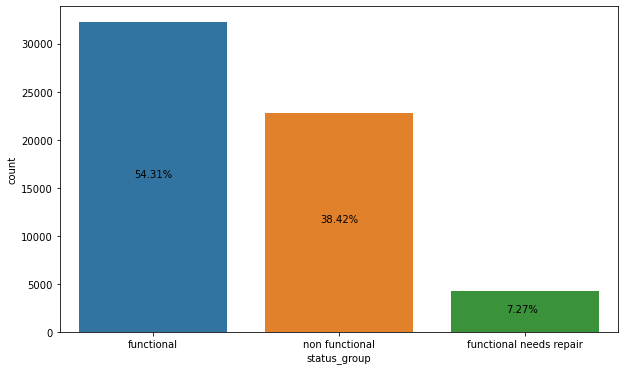

In [8]:
# plot target
plt.subplots(figsize=(10,6))
ax = sns.countplot(x=df_labels['status_group'])
for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()*100/len(df_labels)), (p.get_x()+0.3, p.get_height()*0.5))

In [9]:
# Observamos 3 tipos de estados con diferentes porcentajes. 
# 'Functional needs repair' es la más bajo. 
# La visualización indica que las labels están desequilibradas.

In [10]:
# train 
df_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [11]:
df_train.shape

(59400, 40)

- Los datos de train/labels contienen: 59400 filas y 41 columnas. 

- La variable target - 'status_group' - muestra las labels para cada bomba. Las bombas pueden estar en estos tres estados: Funcional, no-funcional y necesita_reparación.

- Las otras 40 variables corresponden a las características, de las cuales 10 son numéricas (incluyendo 'id') y el resto categóricas.

## 2) Preprocesado 

## 2.1 - EDA 

Analizar los datos (inconsistencia de datos...)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [13]:
numerical_vars = [col for col in df.columns if 
                df[col].dtype in ['int64', 'float64']]
numerical_vars

['id',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

In [14]:
len(numerical_vars)

10

In [15]:
# resumen variables numéricas 
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


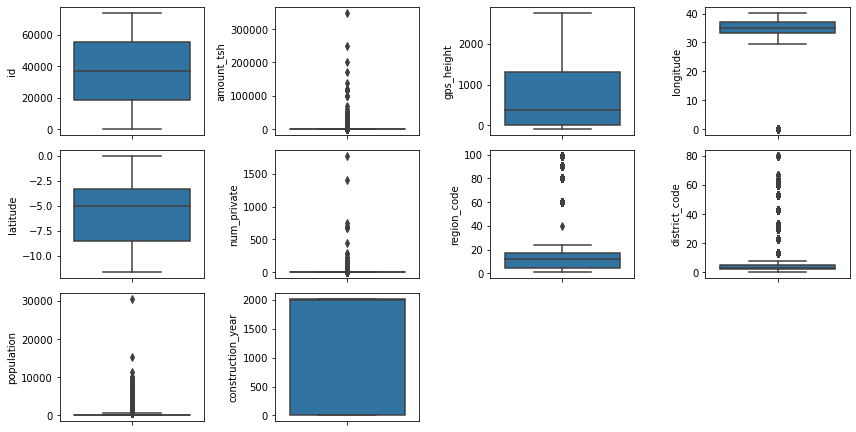

In [16]:
# diagramas de caja para atributos numéricos
fig = plt.figure(figsize=(12, 18))

for i in range(len(numerical_vars)):
    fig.add_subplot(9, 4, i+1)
    sns.boxplot(y=df[numerical_vars].iloc[:,i])

plt.tight_layout()
plt.show()

In [17]:
# categóricas 
df.head() 

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [18]:
# valores nulos 
df.isna().sum() 

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

<AxesSubplot:>

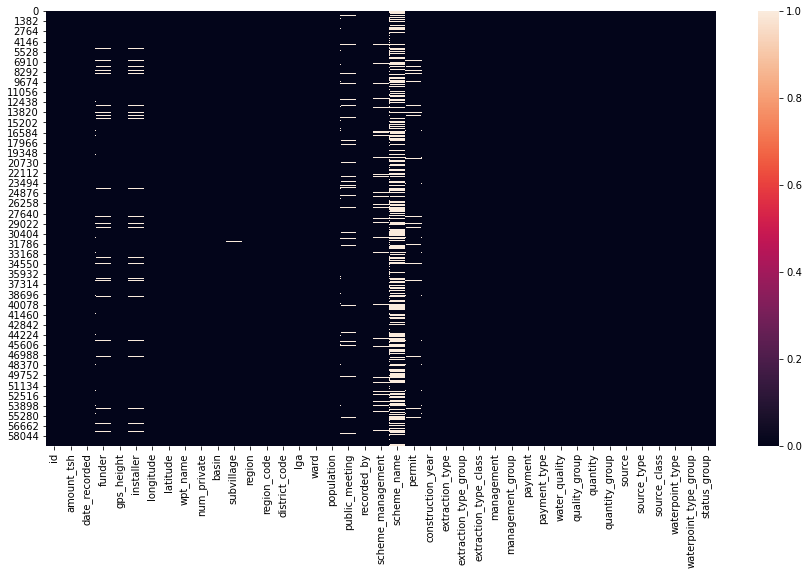

In [19]:
# plot valores nulos
plt.subplots(figsize=(15,8))
sns.heatmap(df.isnull())

<AxesSubplot:title={'center':'Correlation of numerical attributes'}>

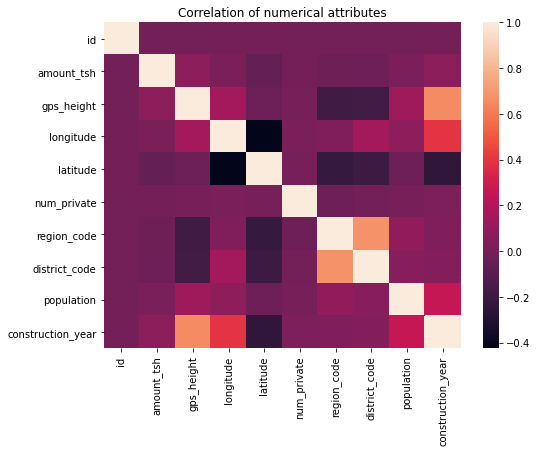

In [20]:
# gráfico de correlación
correlation = df.corr()

f, ax = plt.subplots(figsize=(8,6))
plt.title('Correlation of numerical attributes', size=12)
sns.heatmap(correlation)

In [21]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,59400,NaN,NaN,NaN,37115.1,21453.1,0,18519.8,37061.5,55656.5,74247
amount_tsh,59400,NaN,NaN,NaN,317.65,2997.57,0,0,0,20,350000
date_recorded,59400,356,2011-03-15,572,NaN,NaN,NaN,NaN,NaN,NaN,NaN
funder,55765,1897,Government Of Tanzania,9084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gps_height,59400,NaN,NaN,NaN,668.297,693.116,-90,0,369,1319.25,2770
installer,55745,2145,DWE,17402,NaN,NaN,NaN,NaN,NaN,NaN,NaN
longitude,59400,NaN,NaN,NaN,34.0774,6.56743,0,33.0903,34.9087,37.1784,40.3452
latitude,59400,NaN,NaN,NaN,-5.70603,2.94602,-11.6494,-8.54062,-5.0216,-3.32616,-2e-08
wpt_name,59400,37400,none,3563,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_private,59400,NaN,NaN,NaN,0.474141,12.2362,0,0,0,0,1776


### Primeras observaciones:

- Los valores del target son muy desequilibrados. 
- Algunas columnas contienen datos similares.
- Ciertas variables categóricas tienen demasiados valores únicos.

## 2.2 - Análisis variables - Parte I

Empezamos investigando los valores nulos. 

### 'funder'

In [22]:
# 1) 'funder'
df.funder.value_counts()

Government Of Tanzania         9084
Danida                         3114
Hesawa                         2202
Rwssp                          1374
World Bank                     1349
                               ... 
Kdpa                              1
Luke Samaras Ltd                  1
Motiba Wambura                    1
Resolute Mininggolden Pride       1
Tcrs Kibondo                      1
Name: funder, Length: 1897, dtype: int64

In [23]:
#'funder' tiene una cantidad importante de valores únicos.
# Dependiendo de los resultados, intentaremos eliminarlos o rellenarlos en el feature engineering.
# En un primer momento sustituimos los valores nulos por 'Unknown'.

### 'installer'

In [24]:
# 2) 'installer'
df.installer.value_counts()

DWE                 17402
Government           1825
RWE                  1206
Commu                1060
DANIDA               1050
                    ...  
Zao                     1
Dokta Mwandulami        1
Private company         1
Hussein Ayubu           1
JI                      1
Name: installer, Length: 2145, dtype: int64

In [25]:
# Como 'funder', 'installer' tiene una cantidad importante de valores únicos. 
# Dependiendo de los resultados, intentaremos eliminarlos o rellenarlos en el feature engineering. 
# En un primer momento sustituimos los valores nulos por 'Unknown'.

### 'subvillage'

In [26]:
# 3) 'subvillage'
df.subvillage.value_counts()

Madukani        508
Shuleni         506
Majengo         502
Kati            373
Mtakuja         262
               ... 
Samachi           1
Kasewa            1
Pachanne          1
Kwemziagembe      1
Migungumalo       1
Name: subvillage, Length: 19287, dtype: int64

In [27]:
# 'subvillage' contiene la localización geográfica.
# Ya tenemos otra variable parecida y mejor ('region_code)'. 
# Además 'subvillage' tiene valores únicos. 
# La vamos a eliminar.

### 'public_meeting'

In [28]:
# 4)'public_meeting'
df.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [29]:
# En este caso solo tenemos dos valores: true y false. 
# Guardamos 'public_meeting' 
# Pero tendremos que convertir los booleanos a string y sustituir los nulos.

## 'scheme_management' y 'scheme_name', 

### 'scheme_management'

In [30]:
# 5) 'scheme_management'
df.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [31]:
# Guardamos 'scheme_management' y tendremos que sustitir los nulos.

### 'scheme_name'

In [32]:
# 6) 'scheme_name' 
df.scheme_name.value_counts()

K                            682
None                         644
Borehole                     546
Chalinze wate                405
M                            400
                            ... 
Nike gravity water supply      1
BL Kandashi                    1
Nyabibuye                      1
Kapu chini wster supply        1
Mradi wa maji wa Rusimbi       1
Name: scheme_name, Length: 2696, dtype: int64

In [33]:
# Mejor eliminar 'scheme_name'. 
# Tiene nulos y mucho texto.

### 'permit'

In [34]:
# 7) 'permit'
df.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [35]:
# Guardamos 'permit'.
# Tendremos que hacer como para 'public_meeting' ya que tiene booleanos.

## 2.3 -  Análisis variables - Parte II

Hemos terminado con los valores nulos. Seguimos la investigación.

In [36]:
str_cols = df.select_dtypes(include = ['object'])
str_cols.apply(lambda x: len(x.unique()))

date_recorded              356
funder                    1898
installer                 2146
wpt_name                 37400
basin                        9
subvillage               19288
region                      21
lga                        125
ward                      2092
public_meeting               3
recorded_by                  1
scheme_management           13
scheme_name               2697
permit                       3
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
status_group                 3
dtype: int64

### 'date recorded'


In [37]:
# 8) 'date_recorded'
df.date_recorded.describe()

count          59400
unique           356
top       2011-03-15
freq             572
Name: date_recorded, dtype: object

In [38]:
# La mayoría de los datos se registraron entre 2011-2013. 
# Guardamos 'date_recorded' de momento y vamos a convertirla a Epoch.

### 'wpt_name'

In [39]:
# 9) 'wpt_name'
df.wpt_name.value_counts()

none                3563
Shuleni             1748
Zahanati             830
Msikitini            535
Kanisani             323
                    ... 
Kwa Akisa              1
Kwa Eliwaha Mdee       1
Kwa Anna Msigwa        1
Ngulele                1
Mapela                 1
Name: wpt_name, Length: 37400, dtype: int64

In [40]:
# 'wpt_name' no tiene mucha información.
# La vamos a eliminar.

### 'basin'

In [41]:
# 10) 'basin'
df.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [42]:
# Todos los valores están por encima de 2000.
# 'basin' parece ser una buena variable. 
# La guardamos.

### 'region'

In [43]:
# 11) 'region'
df.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [44]:
#'Region', 'lga' y 'ward' contienen información geográfica.
# Existe el riesgo de que estén correlacionadas. 
# Eliminamos 'region' y usaremos 'region_code'. 
# Eliminamos 'lga' y 'ward' ya que son sus ubicaciones geográficas.

### 'recorded_by'

In [45]:
# 14) 'recorded_by'
df.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [46]:
# 'record_by' solo tiene un valor. 
# La vamos a eliminar.

### 'extraction_type', 'extraction_type_group' y 'extraction_type_class'

### 'extraction_type'

In [47]:
# 15) 'extraction_type'
df.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

### 'extraction_type_group'

In [48]:
# 16) 'extraction_type_group'
df.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

### 'extraction_type_class'

In [49]:
# 17) 'extraction_type_class'
df.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [50]:
# 'extraction_type', 'extraction_type_group' y 'extraction_type_class' tienen datos similares. 
# Guardamos 'extraction_type' y eliminamos las otras.

### 'management' y 'management_group'

### 'management'

In [51]:
# 18) 'management'
df.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

### 'management group'

In [52]:
# 19) 'management_group'
df.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [53]:
# Datos parecidos.
# Vamos a eliminar 'management_group'.

### 'payment' y 'payment_type'

### 'payment'

In [54]:
# 20) 'payment'
df.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

### 'payment_type'

In [55]:
# 21) 'payment_type'
df.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [56]:
# Datos parecidos.  
# Vamos a eliminar 'payment'.

### 'water_quality' y 'quality_group'

### 'water_quality'

In [57]:
# 22) 'water_quality'
df.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

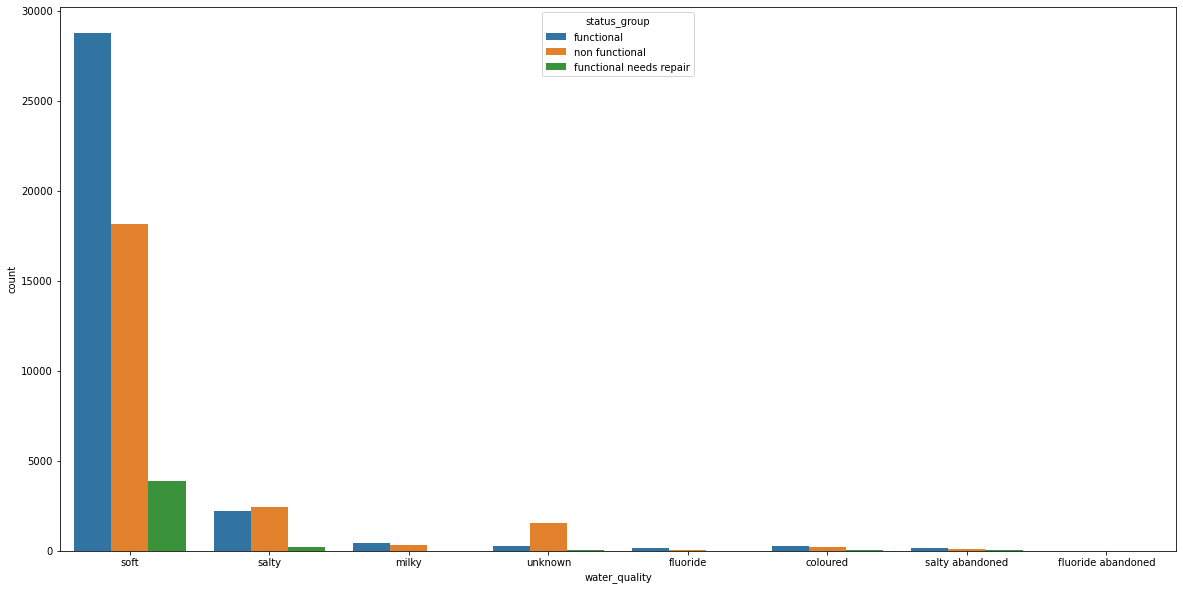

In [58]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='water_quality', hue="status_group", data=df)

### 'quality_group'

In [59]:
# 23) 'quality_group'
df.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

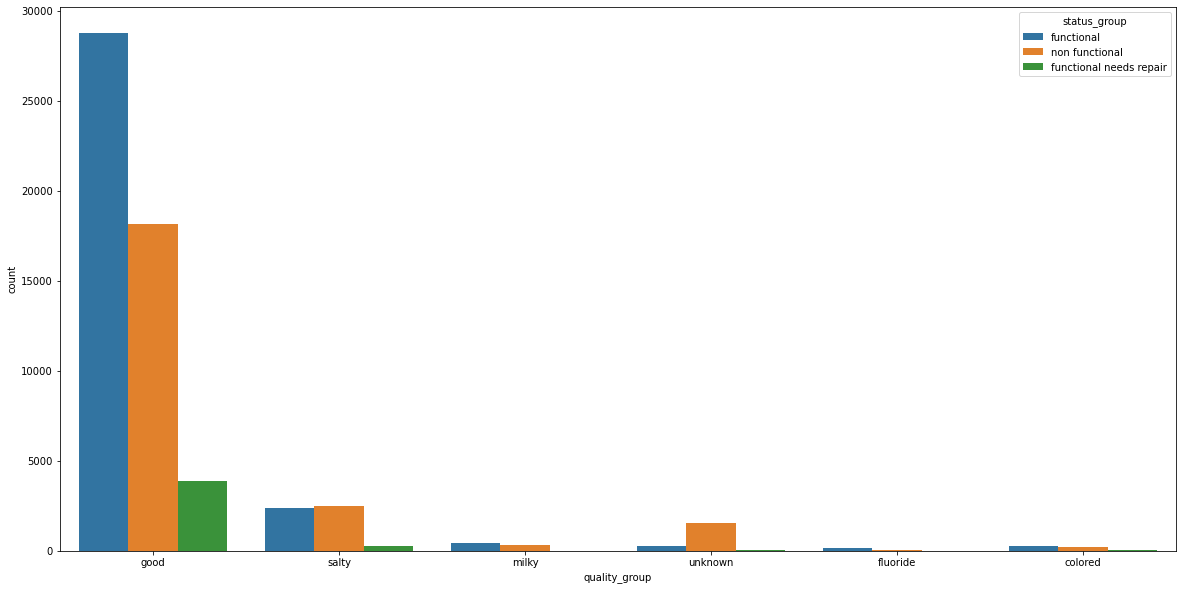

In [60]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='quality_group', hue="status_group", data=df)

In [61]:
# Datos parecidos.
# Vamos a eliminar 'water_quality'.

### 'quantity' y 'quantity_group'

### 'quantity'

In [62]:
# 24) 'quantity'
df.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

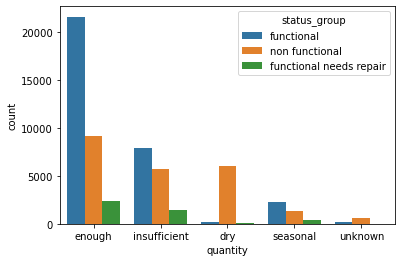

In [63]:
ax = sns.countplot(x='quantity', hue="status_group", data=df)

### 'quantity_group'

In [64]:
# 25) 'quantity_group'
df.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

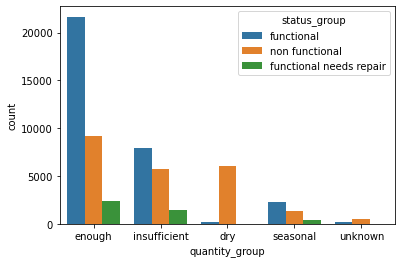

In [65]:
ax = sns.countplot(x='quantity_group', hue="status_group", data=df)

In [66]:
# Contienen la misma información.
# Vamos a eliminar 'quantity'.  

### 'source', 'source_class' y 'source_type'

### 'source'

In [67]:
# 26) 'source'
df.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

### 'source_type'

In [68]:
# 27) 'source_type'
df.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

### 'source_class'

In [69]:
# 28) 'source_class'
df.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [70]:
# Muy similares. 
# Vamos a guardar únicamente 'source'.

### 'waterpoint_type' y 'waterpoint_type_group'

### 'waterpoint_type'

In [71]:
# 29) 'waterpoint_type'
df.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

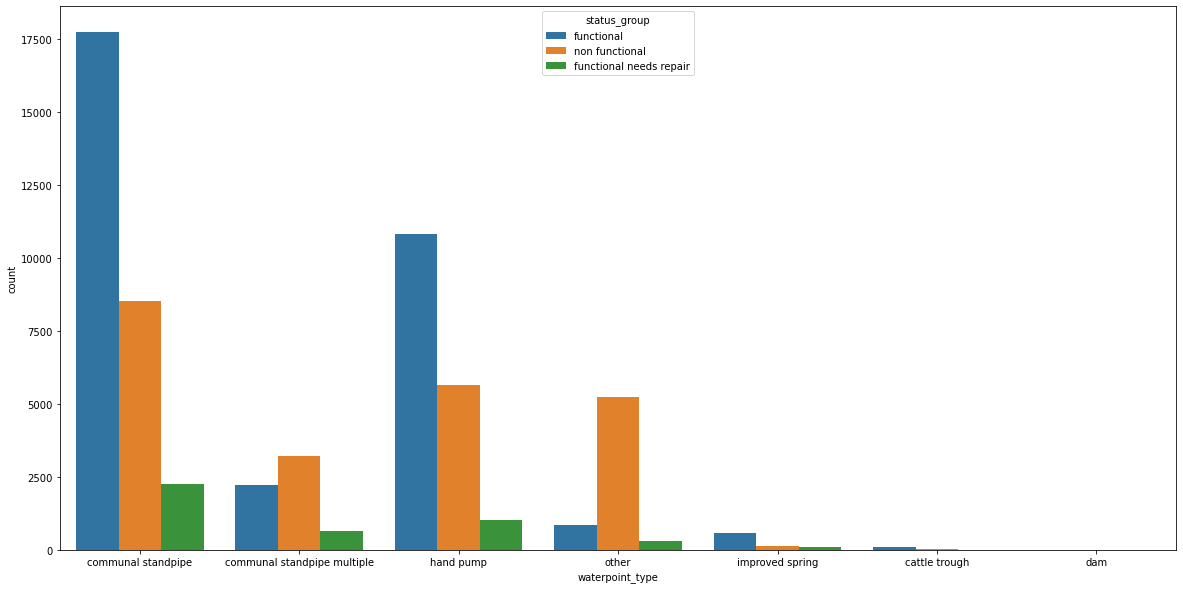

In [72]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='waterpoint_type', hue="status_group", data=df)

###  'waterpoint_type_group'

In [73]:
# 30) 'waterpoint_type_group'
df.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

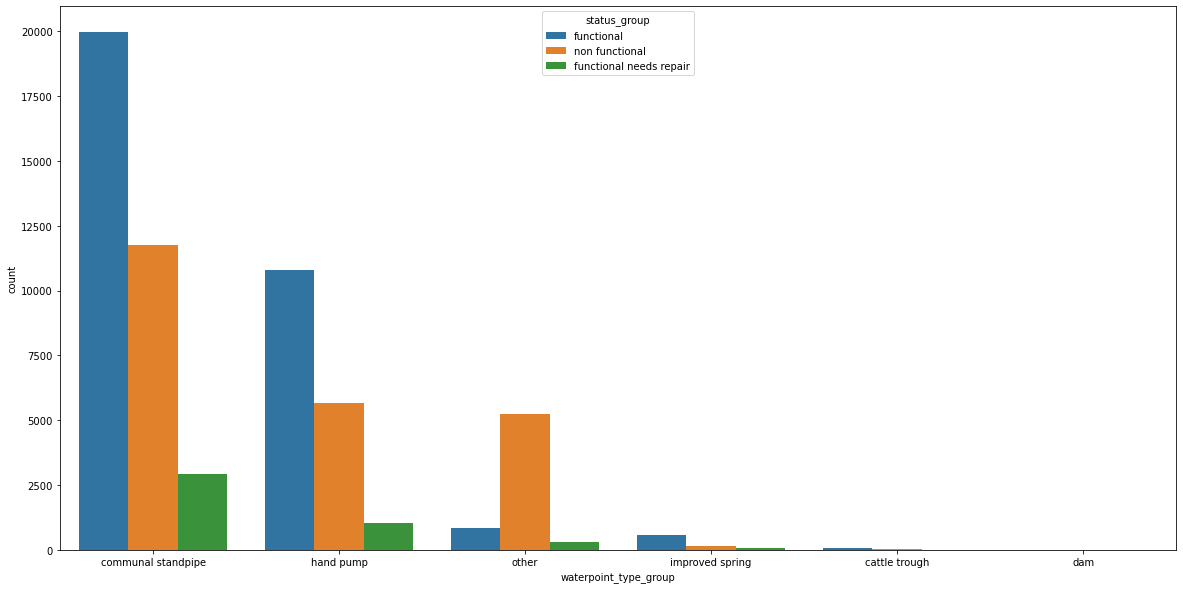

In [74]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='waterpoint_type_group', hue="status_group", data=df)

In [75]:
# Decidimos guardar 'waterpoint_type_group'.
# Los datos de 'waterpoint_type' son parecidos.

### 'gps_height'

In [76]:
# 31) gps_height
df.gps_height.value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

In [77]:
# 'gps_height' contiene la altitud. 
# La guardamos de momento dado que parece tener suficiente información.

### 'longitude' y 'latitude'

In [78]:
# 32) longitude
df.longitude.value_counts()

0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32.972719       2
             ... 
37.579803       1
33.196490       1
34.017119       1
33.788326       1
30.163579       1
Name: longitude, Length: 57516, dtype: int64

In [79]:
# 33) latitude
df.latitude.value_counts()

-2.000000e-08    1812
-6.985842e+00       2
-3.797579e+00       2
-6.981884e+00       2
-7.104625e+00       2
                 ... 
-5.726001e+00       1
-9.646831e+00       1
-8.124530e+00       1
-2.535985e+00       1
-2.598965e+00       1
Name: latitude, Length: 57517, dtype: int64

In [80]:
df.latitude.value_counts()

-2.000000e-08    1812
-6.985842e+00       2
-3.797579e+00       2
-6.981884e+00       2
-7.104625e+00       2
                 ... 
-5.726001e+00       1
-9.646831e+00       1
-8.124530e+00       1
-2.535985e+00       1
-2.598965e+00       1
Name: latitude, Length: 57517, dtype: int64

In [81]:
# 'Longitud', 'latitud' son informaciones geográficas.
# Poco probable que mejoren el modelo. 
# Las vamos a eliminar.

### 'region_code'

In [82]:
# 34) 'region_code'
df.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [83]:
# Guardamos 'region_code' ya que hemos eliminado 'region'.

### 'district_code'

In [84]:
# 35) 'district_code'
df.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [85]:
# La correlación entre 'district_code' y 'region_code' es elevada.
# Pero guardamos las dos de momento.

### 'num_private'

In [86]:
# 36) 'num_private'
df.num_private.value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

In [87]:
# 'num_private' no tiene descripción clara. 
# La vamos a eliminar.

### 'construction_year'

In [88]:
# 37) 'construction_year'
df.construction_year.value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [89]:
# Guardamos 'construction_year' y de momento no la cambiamos. 

### 'population'

In [90]:
# 38) 'population'
df.population.value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

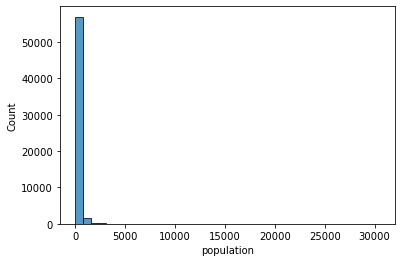

In [91]:
sns.histplot(df.population, bins = 40)
plt.show()

<AxesSubplot:xlabel='population'>

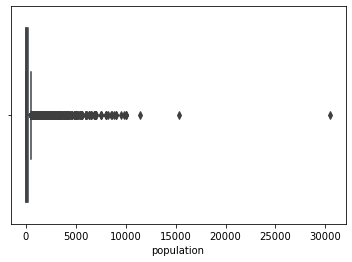

In [92]:
sns.boxplot(x=df.population)

In [93]:
df.population.describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [94]:
print('Outlier for population =', df[df.population > 10000].population.tolist() )

Outlier for population = [15300, 30500, 11463]


In [95]:
# 'population' tiene outliers. 
# De momento la guardamos y no la cambiamos.

### amount_tsh

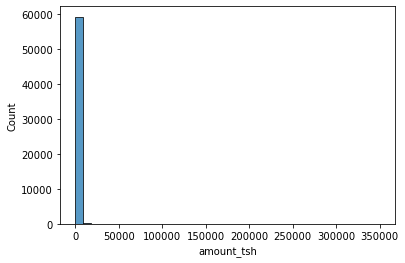

In [96]:
# 39) 'amount_tsh'
sns.histplot(df.amount_tsh, bins = 40)
plt.show()

<AxesSubplot:xlabel='amount_tsh'>

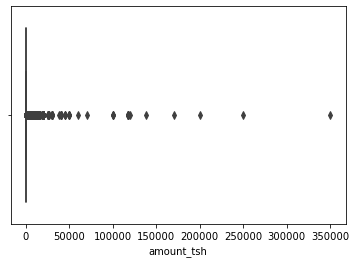

In [97]:
sns.boxplot(x=df.amount_tsh)

In [98]:
df.amount_tsh.describe()

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [99]:
# Vamos a eliminar 'amount_tsh'
# Tinene una cantidad importante de outliers.

# 2.6 - Limpieza y Transformación

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import datetime
from typing import Dict, Tuple

In [101]:
target = pd.read_csv("train_labels.csv")

target = target.replace({'status_group': {'functional' : 1, 
                                          'non functional' : 0, 
                                          'functional needs repair' : 2}})

values = pd.read_csv("train_values.csv")

test = pd.read_csv("test_values.csv")
 
df = values.merge(target, on = 'id')
df.set_index(['id'], inplace=True)

ID = test['id']
test.set_index(['id'], inplace=True)

In [102]:
# target 0, 1 y 2 para modelo
df['status_group'].value_counts()

1    32259
0    22824
2     4317
Name: status_group, dtype: int64

## 2.6.1 - Convertir a cadena (string)

De esta manera sera más fácil transformar las variables en las etapas siguientes.

In [103]:
# train/labels
def convert_to_string(df, column_name):
    df[column_name] = df[column_name].astype(str)

# test
def convert_to_string(test, column_name):
    test[column_name] = test[column_name].astype(str)

In [104]:
convert_to_string(df, 'permit')
convert_to_string(df, 'public_meeting')

convert_to_string(test, 'permit')
convert_to_string(test, 'public_meeting')

## 2.6.2 - Lista categóricas

Creamos una lista con las variables categóricas.

In [105]:
categorical_columns = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga',
                       'ward', 'public_meeting','scheme_management', 'scheme_name', 'permit', 'extraction_type', 
                       'extraction_type_group', 'extraction_type_class','management', 'management_group', 
                       'payment', 'payment_type','water_quality', 'quality_group', 'quantity', 
                       'quantity_group','source', 'source_type', 'source_class', 'waterpoint_type',
                       'waterpoint_type_group','status_group'] 

## 2.6.3 - Valores nulos

Sustituimos los valores nulos por 'Unknown'.

In [106]:
# train/labels
def replace_na_value(df: pd.DataFrame):
    for column in categorical_columns:
        if column not in df.columns:
            continue
        
        df[column] = df[column].fillna('Unknown')

# test
def replace_na_value(test: pd.DataFrame):
    for column in categorical_columns:
        if column not in test.columns:
            continue
        
        test[column] = test[column].fillna('Unknown')

In [107]:
replace_na_value(df)
replace_na_value(test)

## 2.6.4 - Codificación datos categóricos

Codificamos los datos categóricos.

In [108]:
# train/labels
def encode_cat(df: pd.DataFrame) -> Dict[str, LabelEncoder]:
    encoders = {} 
    for column in categorical_columns:
        if column not in df.columns:
            continue
            
        le = LabelEncoder()
        le.fit(df[column])

        df[column] = le.transform(df[column])
        encoders[column]= le
        
    return encoders


# test
def encode_cat(test: pd.DataFrame) -> Dict[str, LabelEncoder]:
    encoders = {} 
    for column in categorical_columns:
        if column not in test.columns:
            continue
            
        le = LabelEncoder()
        le.fit(test[column])

        test[column] = le.transform(test[column])
        encoders[column]= le
        
    return encoders

In [109]:
encoders = encode_cat(df)
encoders = encode_cat(test)

## 2.6.5 -  Convertir fecha 
Convertimos fecha de inserción de datos a epoch time.

In [110]:
date_columns = ['date_recorded']

In [111]:
# train/labels
def convert_to_epoch(df: pd.DataFrame, timestamp_format="%Y-%m-%d"):
    for column in date_columns:
        df[column] = [ datetime.datetime.strptime(x, timestamp_format).timestamp() for x in df[column]]

# test
def convert_to_epoch(test: pd.DataFrame, timestamp_format="%Y-%m-%d"):
    for column in date_columns:
        test[column] = [ datetime.datetime.strptime(x, timestamp_format).timestamp() for x in test[column]]

In [112]:
convert_to_epoch(df)
convert_to_epoch(test)

In [113]:
df['date_recorded'].value_counts()

1.300144e+09    572
1.300316e+09    558
1.359846e+09    546
1.300057e+09    520
1.300230e+09    513
               ... 
1.034546e+09      1
1.327446e+09      1
1.357427e+09      1
1.088633e+09      1
1.385852e+09      1
Name: date_recorded, Length: 356, dtype: int64

## 2.6.6 - Eliminar variables similares

Eliminanos las variables similares y 'record_by' ya que solo tiene un valor.

In [114]:
# train/labels
df = df.drop(['region', 'extraction_type_group', 'extraction_type_class', 'management_group', 'payment', 
              'quality_group', 'quantity', 'source_type', 'source_class', 'waterpoint_type_group', 
              'amount_tsh', 'wpt_name', 'subvillage', 'num_private', 'lga', 'ward', 'scheme_name',
               'longitude', 'latitude', 'recorded_by'], axis=1) 

# test
test = test.drop(['region', 'extraction_type_group', 'extraction_type_class', 'management_group', 'payment', 
              'quality_group', 'quantity', 'source_type', 'source_class', 'waterpoint_type_group', 
              'amount_tsh', 'wpt_name', 'subvillage', 'num_private', 'lga', 'ward', 'scheme_name',
               'longitude', 'latitude', 'recorded_by'], axis=1) 

### Datos preparados 

In [115]:
# tipos todos numéricos 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_recorded      59400 non-null  float64
 1   funder             59400 non-null  int64  
 2   gps_height         59400 non-null  int64  
 3   installer          59400 non-null  int64  
 4   basin              59400 non-null  int64  
 5   region_code        59400 non-null  int64  
 6   district_code      59400 non-null  int64  
 7   population         59400 non-null  int64  
 8   public_meeting     59400 non-null  int64  
 9   scheme_management  59400 non-null  int64  
 10  permit             59400 non-null  int64  
 11  construction_year  59400 non-null  int64  
 12  extraction_type    59400 non-null  int64  
 13  management         59400 non-null  int64  
 14  payment_type       59400 non-null  int64  
 15  water_quality      59400 non-null  int64  
 16  quantity_group    

In [116]:
# data frame limpio
df.isna().sum()

date_recorded        0
funder               0
gps_height           0
installer            0
basin                0
region_code          0
district_code        0
population           0
public_meeting       0
scheme_management    0
permit               0
construction_year    0
extraction_type      0
management           0
payment_type         0
water_quality        0
quantity_group       0
source               0
waterpoint_type      0
status_group         0
dtype: int64

### Train Model y Predict

In [117]:
# lista de features training y target para predicciones 
features = ['funder', 'gps_height', 'installer', 'basin', 'region_code', 'district_code', 
          'scheme_management', 'permit', 'extraction_type', 'management', 
            'payment_type', 'water_quality', 'quantity_group', 'source',
          'waterpoint_type', 'construction_year', 'population', 'date_recorded'] 


target = ['status_group']
df_pump_X = df[features]
df_pump_Y = df[target]

# test
df_pump_test = test[features]

In [118]:
# variables con las que nos quedamos en 'features'
df_pump_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   funder             59400 non-null  int64  
 1   gps_height         59400 non-null  int64  
 2   installer          59400 non-null  int64  
 3   basin              59400 non-null  int64  
 4   region_code        59400 non-null  int64  
 5   district_code      59400 non-null  int64  
 6   scheme_management  59400 non-null  int64  
 7   permit             59400 non-null  int64  
 8   extraction_type    59400 non-null  int64  
 9   management         59400 non-null  int64  
 10  payment_type       59400 non-null  int64  
 11  water_quality      59400 non-null  int64  
 12  quantity_group     59400 non-null  int64  
 13  source             59400 non-null  int64  
 14  waterpoint_type    59400 non-null  int64  
 15  construction_year  59400 non-null  int64  
 16  population        

### Multicolinealidad - VIF 

In [119]:
from sklearn.linear_model import LinearRegression

df = df.copy(deep = True)
features = list(df.columns)
df = df[features]

for i in range(len(features)):
    var = features[i]
    fet = features[:]
    fet.remove(var)
    
    x = df[fet]
    y = df[var]
    
    model = LinearRegression()
    model.fit(x, y)
    
    vif = 1 / (1 - model.score(x, y))
    
    print ('VIF for variable', var, 'is:', vif)

VIF for variable date_recorded is: 1.3933825413123073
VIF for variable funder is: 1.6398042619386897
VIF for variable gps_height is: 2.5988283289340197
VIF for variable installer is: 1.644653269845828
VIF for variable basin is: 1.5389934902417675
VIF for variable region_code is: 2.0931421672782573
VIF for variable district_code is: 1.9812105674562936
VIF for variable population is: 1.1016105982193996
VIF for variable public_meeting is: 1.0425658087636958
VIF for variable scheme_management is: 1.9184300730846817
VIF for variable permit is: 1.1018913473129237
VIF for variable construction_year is: 2.7480496931933063
VIF for variable extraction_type is: 1.376580060462604
VIF for variable management is: 1.9990989256566192
VIF for variable payment_type is: 1.187438419949294
VIF for variable water_quality is: 1.0596373411319284
VIF for variable quantity_group is: 1.059299972552502
VIF for variable source is: 1.2330338507595078
VIF for variable waterpoint_type is: 1.347766775696963
VIF for va

In [120]:
# En los resultados se puede observar que no hay variables que tienen valores por encima de 5.

# 2.7 - Save data

In [121]:
#df.to_csv('train_models.csv')
df_pump = df.copy() 

# 2.8 - Split data

In [122]:
X_train, X_test, y_train, y_test = train_test_split(df_pump_X, df_pump_Y, test_size=1/5, random_state=42)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(47520, 18) (47520, 1)
(11880, 18) (11880, 1)


## 2.9 - Train models

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import datetime
from typing import Dict, Tuple

In [124]:
models_result = {}

In [125]:
def result_print(models_result, model_name, clf, X_test, y_test):
    accuracy = clf.score(X_test, y_test)

    models_result[model_name] = accuracy
    print(f'"{model_name}" has accuracy: {accuracy}')

# 3) Validación cruzada

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [127]:
len(df_pump.columns)

20

In [128]:
## Variable target quality

x_pump = df_pump.iloc[:, 0:19].values
y_pump = df_pump.iloc[:, 19].values

X_train, X_test, y_train, y_test = train_test_split(x_pump, y_pump, test_size=0.2, random_state=42)

In [129]:
model1 = RandomForestClassifier(n_estimators=100, random_state=0)

In [130]:
results = cross_val_score(estimator=model1, X=X_train, y=y_train, cv=5)

In [131]:
results

array([0.7924032 , 0.79619108, 0.7940867 , 0.79419192, 0.79229798])

In [132]:
print(results.mean())

0.793834175084175


In [133]:
print(results.std())

0.0014250844236815706


In [134]:
# Observamos que la varianza del modelo es muy baja, pese a entrenarse 5 veces con 5 subsets random. 
# Significa que no ha sido una predicción casual.

# 4) Clasificación 

In [135]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import naive_bayes

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot  as plt

## 4.1 - Regresión logística


In [136]:
def linear(X_train, y_train):
    clf_lr = SGDClassifier(loss='log',random_state=0)

    
    clf_lr.fit(X_train, y_train)
    
    return clf_lr

In [137]:
linear_clf = linear(X_train, y_train)
result_print(models_result, 'Logistic Regression', linear_clf, X_test, y_test)

"Logistic Regression" has accuracy: 0.5435185185185185


In [139]:
# Obtenemos 54% con la regresión logística.

## 4.2 - Random Forest

In [140]:
def random_forest(X_train, y_train):
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(max_depth=25, n_estimators = 42*5, criterion = 'entropy', random_state = 0)

    clf.fit(X_train, y_train)
    
    return clf

In [141]:
rf_clf = random_forest(X_train, y_train)
result_print(models_result, 'Random Forest', rf_clf, X_test, y_test)

"Random Forest" has accuracy: 0.8034511784511784


In [146]:
# Obtenemos 80% con Random Forest.

## 4.3 - SVM

In [147]:
def svm(X_train, y_train):
    from sklearn.svm import LinearSVC 
    clf = LinearSVC()
    
    clf.fit(X_train, y_train)
    
    return clf

In [148]:
svm_clf = svm(X_train, y_train)
result_print(models_result, 'Support Vector Machine', svm_clf, X_test, y_test)

"Support Vector Machine" has accuracy: 0.5435185185185185


/Users/xavieraage/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## 4.4 - Naive Bayes

In [150]:
def gaussian_nb(X_train, y_train):
    from sklearn.naive_bayes import GaussianNB
    clf = GaussianNB()
    
    clf.fit(X_train, y_train)
    
    return clf

In [151]:
bayes_clf = gaussian_nb(X_train, y_train)
result_print(models_result, 'Naive Bayes', bayes_clf, X_test, y_test)

"Naive Bayes" has accuracy: 0.5391414141414141


In [154]:
# Obtenemos 54% con Naive Bayes.

## 4.5 - Árboles de decisión

In [155]:
def decision_tree(X_train, y_train):
    from sklearn.tree import DecisionTreeClassifier
    clf = DecisionTreeClassifier()
    
    clf.fit(X_train, y_train)
    
    return clf

In [156]:
tree_clf = decision_tree(X_train, y_train)
result_print(models_result, 'Árboles de decisión', tree_clf, X_test, y_test)

"Árboles de decisión" has accuracy: 0.7508417508417509


In [158]:
# Obtenemos 75% con Árboles de decisión.

# 5) Ensemble models

## XGBoost

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

In [160]:
X_train, X_test, y_train, y_test = train_test_split(df_pump_X, df_pump_Y, test_size=1/5, random_state=42)

In [163]:
# Habíamos obtenido el mismo resultado sin usar "ravel()"
# Usando "ravel()" obtenemos el mismo resultado pero sin el DataConversionWarning 

def xgb(X_train, y_train):
    from xgboost import XGBClassifier
    clf = XGBClassifier(nthread=2, num_class=3, 
                        min_child_weight=3, max_depth=15,
                        gamma=0.5, scale_pos_weight=0.8,
                        subsample=0.7, colsample_bytree = 0.8,
                        objective='multi:softmax')
    clf.fit(X_train, y_train.values.ravel())
    
    return clf

In [164]:
xgb_clf = xgb(X_train, y_train)
result_print(models_result, 'XGBoost', xgb_clf, X_test, y_test)

[11:20:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


"XGBoost" has accuracy: 0.8018518518518518


In [169]:
# Obtenemos 80% con XGBoost.

# 6) Mejora de modelos

## 6.1 - Selección de variables

In [170]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split


from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression 
from sklearn.feature_selection import chi2 
from sklearn.feature_extraction.text import HashingVectorizer

In [171]:
df_pump.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_recorded      59400 non-null  float64
 1   funder             59400 non-null  int64  
 2   gps_height         59400 non-null  int64  
 3   installer          59400 non-null  int64  
 4   basin              59400 non-null  int64  
 5   region_code        59400 non-null  int64  
 6   district_code      59400 non-null  int64  
 7   population         59400 non-null  int64  
 8   public_meeting     59400 non-null  int64  
 9   scheme_management  59400 non-null  int64  
 10  permit             59400 non-null  int64  
 11  construction_year  59400 non-null  int64  
 12  extraction_type    59400 non-null  int64  
 13  management         59400 non-null  int64  
 14  payment_type       59400 non-null  int64  
 15  water_quality      59400 non-null  int64  
 16  quantity_group    

In [172]:
target = 'status_group'
features = list(df_pump.columns)
features.remove('status_group')

x = df_pump[features]
y = df_pump[target]

In [173]:
## Eliminar variables con baja varianza

In [174]:
var_th = VarianceThreshold(threshold = 0.60) 
x_var = var_th.fit_transform(x)

In [175]:
x_var

array([[1.3000572e+09, 1.3690000e+03, 1.3900000e+03, ..., 1.0000000e+00,
        8.0000000e+00, 1.0000000e+00],
       [1.3625244e+09, 4.6900000e+02, 1.3990000e+03, ..., 2.0000000e+00,
        5.0000000e+00, 1.0000000e+00],
       [1.3617468e+09, 8.2500000e+02, 6.8600000e+02, ..., 1.0000000e+00,
        0.0000000e+00, 2.0000000e+00],
       ...,
       [1.3024728e+09, 1.7500000e+03, 0.0000000e+00, ..., 1.0000000e+00,
        3.0000000e+00, 4.0000000e+00],
       [1.2995388e+09, 8.8400000e+02, 0.0000000e+00, ..., 2.0000000e+00,
        7.0000000e+00, 4.0000000e+00],
       [1.3008348e+09, 1.8650000e+03, 1.9100000e+02, ..., 1.0000000e+00,
        7.0000000e+00, 4.0000000e+00]])

In [176]:
x.shape[1] ## variables principales

19

In [177]:
x_var.shape[1] ## variables finales

17

In [178]:
np.asarray(list(x))[var_th.get_support()]

array(['date_recorded', 'funder', 'gps_height', 'installer', 'basin',
       'region_code', 'district_code', 'population', 'scheme_management',
       'construction_year', 'extraction_type', 'management',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'waterpoint_type'], dtype='<U17')

In [179]:
# Faltan las variables 'permit' y 'public_meeting'

## 6.2 - Forward stepwise

In [180]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [181]:
model = LinearRegression()
feature_order =  []
feature_error = []

for i in range(len(features)):
    idx_try = [val for val in range(len(features)) if val not in feature_order]
    iter_error = []

    for i_try in idx_try:
        useRow = feature_order[:]
        useRow.append(i_try)

        use_train = x_train[x_train.columns[useRow]]
        use_test = x_test[x_train.columns[useRow]]

        model.fit(use_train, y_train)
        rmsError = np.linalg.norm((y_test - model.predict(use_test)), 2)/np.sqrt(len(y_test))
        iter_error.append(rmsError)

    pos_best = np.argmin(iter_error)
    feature_order.append(idx_try[pos_best])
    feature_error.append(iter_error[pos_best])

for i in range(len(features)):
    print ("En el paso", i, "se ha insertado la variable", features[feature_order[i]], "con un error", feature_error[i])

En el paso 0 se ha insertado la variable waterpoint_type con un error 0.5898550439681894
En el paso 1 se ha insertado la variable quantity_group con un error 0.5827180895435695
En el paso 2 se ha insertado la variable management con un error 0.5796307441268569
En el paso 3 se ha insertado la variable payment_type con un error 0.5770560581778087
En el paso 4 se ha insertado la variable source con un error 0.5754670035435606
En el paso 5 se ha insertado la variable funder con un error 0.5747451357754502
En el paso 6 se ha insertado la variable gps_height con un error 0.5744181594046062
En el paso 7 se ha insertado la variable construction_year con un error 0.5739847202936909
En el paso 8 se ha insertado la variable water_quality con un error 0.573616250461844
En el paso 9 se ha insertado la variable population con un error 0.5733325139712976
En el paso 10 se ha insertado la variable date_recorded con un error 0.5731710948231468
En el paso 11 se ha insertado la variable extraction_type co

In [182]:
# 'waterpoint_type' y 'quantity_group' tienen los errores más importantes.
# No obstante no son errores significativos en comparación con las otras variables.

## 6.3 - Mejora de modelos

### Feature engineering 

In [183]:
# Mejora de modelos a través de la creación de nuevas variables 

In [184]:
df_improv = df_pump.copy() 

In [185]:
# De acuerdo con la observación anterior, eliminamos 'permit' y 'public meeting'

In [186]:
df_improv.drop(columns=['public_meeting','permit'],inplace=True )

In [187]:
# 'funder'

In [188]:
df_improv['funder'].fillna(value='Unknown',inplace=True)
df_improv['funder'].replace(to_replace = '0', value ='Unknown' , inplace=True)

In [189]:
df1 = df_improv.loc[df_improv['funder']== 'Government Of Tanzania']
df2 = df_improv.loc[df_improv['funder']== 'Unknown']              
df3 = df_improv.loc[df_improv['funder']== 'Danida'] 
df4 = df_improv.loc[df_improv['funder']== 'Hesawa'] 
df5 = df_improv.loc[df_improv['funder']== 'Rwssp'] 
df6 = df_improv.loc[df_improv['funder']== 'World Bank'] 
df7 = df_improv.loc[df_improv['funder']== 'Kkkt'] 
df8 = df_improv.loc[df_improv['funder']== 'World Vision']
df9 = df_improv.loc[df_improv['funder']== 'Unicef'] 
df10 = df_improv.loc[df_improv['funder']== 'Tasaf'] 
df11 = df_improv.loc[df_improv['funder']== 'District Council'] 
df12 = df_improv.loc[df_improv['funder']== 'Dhv'] 
df13 = df_improv.loc[df_improv['funder']== 'Private Individual'] 
df14 = df_improv.loc[df_improv['funder']== 'Dwsp'] 
df15 = df_improv.loc[df_improv['funder']== 'Norad'] 
df16 = df_improv.loc[df_improv['funder']== 'Germany Republi']
df17 = df_improv.loc[df_improv['funder']== 'Tcrs']
df18 = df_improv.loc[df_improv['funder']== 'Ministry Of Water']
df19 = df_improv.loc[df_improv['funder']== 'Water']
df20 = df_improv.loc[df_improv['funder']== 'Dwe']

In [190]:
df_improv['funder_nueva'] = df_improv['funder']

c_fund = ['Danida','Unknown','Government Of Tanzania','Hesawa','Rwssp','World Bank','Kkkt', 'World Vision',
         'Unicef','Tasaf','District Council', 'Dhv', 'Private Individual', 'Dwsp','Norad','Germany Republi',
         'Tcrs','Ministry Of Water','Water','Dwe']
    

df_improv.loc[~df_improv["funder_nueva"].isin(c_fund), "funder_nueva"] = "Others"

In [191]:
# 'installer'

In [192]:
df_improv['installer'].fillna(value='Unknown',inplace=True) 


In [193]:
df_improv['installer'].replace(to_replace = '0', value ='Unknown' , inplace=True) 

In [194]:
df_1 = df_improv.loc[df_improv['installer']== 'DWE']
df_2 = df_improv.loc[df_improv['installer']== 'Unknown']              
df_3 = df_improv.loc[df_improv['installer']== 'Government'] 
df_4 = df_improv.loc[df_improv['installer']== 'Community'] 
df_5 = df_improv.loc[df_improv['installer']== 'DANIDA'] 
df_6 = df_improv.loc[df_improv['installer']== 'RWE'] 
df_7 = df_improv.loc[df_improv['installer']== 'District council'] 
df_8 = df_improv.loc[df_improv['installer']== 'Central government']
df_9 = df_improv.loc[df_improv['installer']== 'KKKT'] 
df_10 = df_improv.loc[df_improv['installer']== 'HESAWA'] 
df_11 = df_improv.loc[df_improv['installer']== 'TCRS'] 
df_12 = df_improv.loc[df_improv['installer']== 'world vision'] 
df_13 = df_improv.loc[df_improv['installer']== 'CES'] 
df_14 = df_improv.loc[df_improv['installer']== 'Fini Water'] 
df_15 = df_improv.loc[df_improv['installer']== 'RC Church'] 
df_16 = df_improv.loc[df_improv['installer']== 'villagers']
df_17 = df_improv.loc[df_improv['installer']== 'LGA']

In [195]:
df_improv['installer_nueva'] = df_improv['installer'] 

In [196]:
c_ins = ['DWE','Unknown','Government','Community','DANIDA','RWE','District council', 'Central government',
         'KKKT','HESAWA','TCRS', 'world vision', 'Fini Water', 'RC Church','villagers','LGA']


df_improv.loc[~df_improv["installer_nueva"].isin(c_ins), "installer_nueva"] = "Others"


In [197]:
# drop 

In [198]:
df_improv.drop(columns=['funder','installer'],inplace=True )

In [199]:
def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
df_improv['construction_year'] = df_improv.apply(lambda row: construction_wrangler(row), axis=1)

In [200]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
categorical_features = ['funder_nueva','installer_nueva', 'construction_year']

df_improv[categorical_features] = df_improv[categorical_features].apply(encoder.fit_transform)

In [201]:
df_improv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_recorded      59400 non-null  float64
 1   gps_height         59400 non-null  int64  
 2   basin              59400 non-null  int64  
 3   region_code        59400 non-null  int64  
 4   district_code      59400 non-null  int64  
 5   population         59400 non-null  int64  
 6   scheme_management  59400 non-null  int64  
 7   construction_year  59400 non-null  int64  
 8   extraction_type    59400 non-null  int64  
 9   management         59400 non-null  int64  
 10  payment_type       59400 non-null  int64  
 11  water_quality      59400 non-null  int64  
 12  quantity_group     59400 non-null  int64  
 13  source             59400 non-null  int64  
 14  waterpoint_type    59400 non-null  int64  
 15  status_group       59400 non-null  int64  
 16  funder_nueva      

In [202]:
features_improve = ['funder_nueva', 'gps_height', 'installer_nueva', 'basin', 'region_code', 'district_code', 
          'scheme_management',  'extraction_type', 'management', 
            'payment_type', 'water_quality', 'quantity_group', 'source',
          'waterpoint_type', 'construction_year', 'population', 'date_recorded']  
        

target = ['status_group']
df_X_imp = df_improv[features_improve]
df_Y_imp = df[target]

In [203]:
X_train, X_test, y_train, y_test = train_test_split(df_X_imp, df_Y_imp, test_size=1/5, random_state=42)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(47520, 17) (47520, 1)
(11880, 17) (11880, 1)


### Random Forest 1

In [205]:
# Habíamos obtenido el mismo resultado sin usar "ravel()"
# Usando "ravel()" obtenemos el mismo resultado pero sin el DataConversionWarning 

clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, y_train.values.ravel())

print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      4572
           1       0.81      0.86      0.83      6457
           2       0.47      0.36      0.41       851

    accuracy                           0.79     11880
   macro avg       0.70      0.66      0.68     11880
weighted avg       0.78      0.79      0.79     11880



In [209]:
# Obtenemos 79% con Random Forest - habíamos obtenido 80% antes.
# El Feature Engineering no ha mejorado el modelo.
# A pesar de haber tratado los valores únicos de 'funder' y 'installer'.

# 7) Automatización de modelos 

In [210]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [211]:
X_train, X_test, y_train, y_test = train_test_split(df_pump_X, df_pump_Y, test_size=1/5, random_state=42)

# 7.1 - Grid search 

In [212]:
grid_param = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [213]:
model_grid = GridSearchCV(estimator=model1,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [215]:
# Habíamos obtenido el mismo resultado sin usar "ravel()"
# Usando "ravel()" obtenemos el mismo resultado pero sin el DataConversionWarning 

model_grid.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 300, 500, 800, 1000]},
             scoring='accuracy')

In [216]:
print(model_grid.best_params_)

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 300}


In [217]:
print(model_grid.best_score_)

0.7954545454545454


# 8) Resultado modelos

In [218]:
for k,v in sorted(models_result.items(), key=lambda entry:entry[1], reverse=True):
    print(f'{k:25s} {v}')

Random Forest             0.8034511784511784
XGBoost                   0.8018518518518518
Árboles de decisión       0.7508417508417509
Logistic Regression       0.5435185185185185
Support Vector Machine    0.5435185185185185
Naive Bayes               0.5391414141414141


In [219]:
# El mejor modelo es Random Forest: 0.8034
# XGBoost también es bueno ya que hemos obtenido 0.8018
# Los resultdados de XGBoost y Random Forest son similares.

# 9) Predicciones

In [220]:
# Habíamos obtenido el mismo resultado sin usar "ravel()"
# Usando "ravel()" obtenemos el mismo resultado pero sin el DataConversionWarning 

model_final = RandomForestClassifier(bootstrap =  True, criterion = 'entropy', n_estimators = 1000)
model_final.fit(df_pump_X,df_pump_Y.values.ravel())

RandomForestClassifier(criterion='entropy', n_estimators=1000)

In [221]:
final_preds = model_final.predict(df_pump_test)

In [222]:
preds = pd.concat([ID, pd.Series(final_preds, name = 'status_group')], axis=1)

preds = preds.replace({'status_group': {1 : 'functional', 
                                        0 : 'non functional', 
                                        2 : 'functional needs repair'}})
preds

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


# 10) Crear archivo

In [223]:
preds.to_csv('preds.csv', index = False)  